In [1]:
#To generate statistics for the papaer WD2017
#Fernando Wario
#May 2017

%matplotlib notebook

import os
import csv
import cv2
import json
import sys
import glob
import math
import datetime
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from sklearn import preprocessing
from sklearn.linear_model import TheilSenRegressor
from skimage.transform import radon, rescale
from scipy.stats import multivariate_normal
from scipy import stats

sys.path.append('../functions/')
sys.path.append('../utils/')

from DoG import DoG
from file_manager import File_manager
from wdd_decoder_functions import read_DD, def_orientation, subst_angles

#Radian
radi = 180/np.pi

In [2]:
#GROUND TRUTH DATA
#Path to the Ground Truth data
path = '../Data/GTData'
folders = os.listdir(path)

#Ground Truth data is loaded
GTArray = {}

for i in folders:    
    #Path to next GT file
    inputFile = os.path.join(path,i)
    print('working on ' + inputFile)
    with open(inputFile, 'rt', encoding='utf-8-sig') as GTFile:
        for row in csv.reader(GTFile, delimiter = ','):
            key = row[0]
            #If it is the first time this WR is registered
            if (key not in GTArray):
                GTArray[key] = [float(row[-1])]
            #If not, it is added
            else:
                GTArray[key].append(float(row[-1]))

#DOT DETECTOR DATA
#Path to the Dot Detector data
path = '../Data/GTRuns/'
#Dot Detector data is loaded
DDArray = {}
DDArray = read_DD(path)
print('done with DDArray!')            

#DECODER DATA
#Path to the Decoder data
inputFile = '../Data/GTRuns_decoder.csv'

#Decoder data is loaded
DecArray = {}
with open(inputFile, 'rt', encoding='utf-8-sig') as DecFile:
    reader2 = csv.reader(DecFile, delimiter=',')
    #skiping header
    next(reader2)
    for row in reader2:    
        DecArray[row[0]] = float(row[2])*radi
    print('done with DecArray!')    

#Average and error data is computed
#Average Ground Truth
AvgGTArray = {}
#Error Ground Truth
ErrGTArray = {}
#Error Decoder
ErrDecArray = {}
for v in GTArray:
    #Average Ground Truth is computed using circular statistics with appropriate range
    AvgGTArray[v] = stats.circmean(GTArray[v], high=180, low=-180)
    #Error Decoder is computed using the function subst_angles()
    ErrDecArray[v] = subst_angles(AvgGTArray[v],DecArray[v])    
    #Error Ground Truth is computed using the function subst_angles()
    for i in GTArray[v]:
        if (v not in ErrGTArray):
            ErrGTArray[v] = [subst_angles(AvgGTArray[v],i)]
        #If not, it is added
        else:
            ErrGTArray[v].append(subst_angles(AvgGTArray[v],i))
print('done with AvGTArray, ErrGTArray and ErrDecArray')

working on ../Data/GTData\20170504_1318.csv
working on ../Data/GTData\20170522_1219.csv
working on ../Data/GTData\20170522_1418.csv
working on ../Data/GTData\20170522_1731.csv
working on ../Data/GTData\20170529_1449.csv
working on ../Data/GTData\20170529_1546.csv
working on ../Data/GTData\20170613_1108.csv
working on ../Data/GTData\20170619_1229.csv
done with DDArray!
done with DecArray!
done with AvGTArray, ErrGTArray and ErrDecArray


1600
mean = 0.00447094358114
std = 6.66221228021


<IPython.core.display.Javascript object>


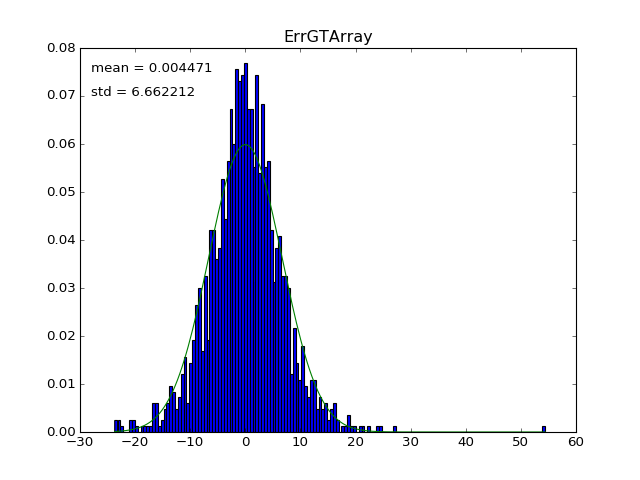

In [3]:
#Graphic ErrGTArray distribution (each GT file)
lim = 140
#An array containing all keys to WRuns with errors over the limit is generated
ErrGTKey = [key for key, value in ErrGTArray.items() if np.max(np.abs(value)) > lim]
#and the errors under that limit
list_values = [value for key, value in ErrGTArray.items() if np.max(np.abs(value)) < lim]

list_values = np.array(list_values)

list_values = list_values[np.logical_and(list_values>-lim,list_values<lim)]

print(len(list_values))

mean=np.mean(list_values)
sigma=np.std(list_values)

print('mean = ' + str(mean))
print('std = ' + str(sigma))

fig1 = plt.figure()
plt.hist(list_values, bins=150, normed=True)

x = np.linspace(np.amin(list_values), np.amax(list_values), 200)
plt.plot(x, mlab.normpdf(x, mean, sigma))

plt.annotate('mean = %5.6f' %mean, xy=(-28, .075))
plt.annotate('std = %5.6f' %sigma, xy=(-28, .07))

plt.title("ErrGTArray")
plt.show()

181
mean = -2.92038091535
std = 7.36883242338


<IPython.core.display.Javascript object>


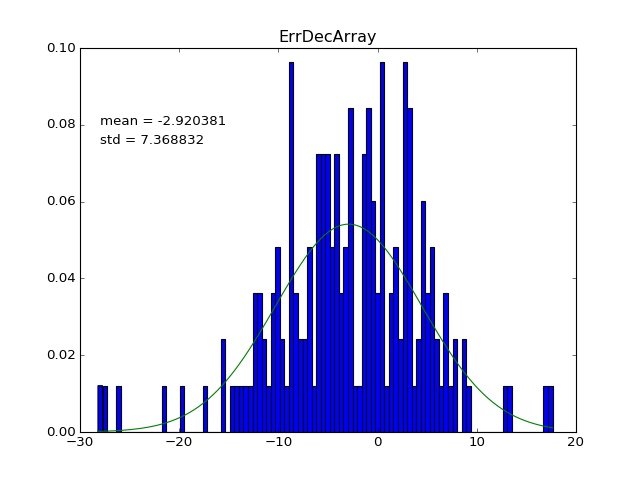

In [4]:
#Graphic ErrDecArray distribution
lim = 150

#For ErrDecArray
#An array containing all keys to WRuns with errors over the limit is generated
ErrDecKey = [key for key, value in ErrDecArray.items() if np.max(np.abs(value)) > lim]
#and the errors under that limit
list_values = [value for key, value in ErrDecArray.items() if np.max(np.abs(value)) < lim]

list_values = np.array(list_values)

print(len(list_values))

mean=np.mean(list_values)
sigma=np.std(list_values)

print('mean = ' + str(mean))
print('std = ' + str(sigma))

fig2 = plt.figure()
plt.hist(list_values, bins=100, normed=True)

x = np.linspace(min(list_values), max(list_values), 100)
plt.plot(x, mlab.normpdf(x, mean, sigma))

plt.annotate('mean = %5.6f' %mean, xy=(-28, .08))
plt.annotate('std = %5.6f' %sigma, xy=(-28, .075))

plt.title("ErrDecArray")
plt.show()

In [16]:
#Graphic ErrCluster distribution

#Reading data from GTClusters.csv
GTFile = '../Data/GTClusters.csv'
GTClusters = {}
with open(GTFile, 'rt', encoding='utf-8-sig') as GTClusterFile:    
    reader3 = csv.reader(GTClusterFile, delimiter=',', quotechar='', quoting=csv.QUOTE_NONE)
    #skiping header
    next(reader3)
    for row in reader3:    
        GTClusters[row[0]] = float(row[1])*radi, row[3:]
    print('done with %3d GTClusters!' %len(GTClusters))
#print(GTClusters)

#Reading data from GTAverage.csv
AvgGTFile = '../Data/GTAverage.csv'
AvgGTArray = {}
with open(AvgGTFile, 'rt', encoding='utf-8-sig') as AvgGT:
    reader4 = csv.reader(AvgGT, delimiter=',')    
    #skiping header
    next(reader4)
    for row in reader4:    
        AvgGTArray[row[0]] = float(row[1])*radi
    print('done with AvgGTArray!')

#AvgGT per cluster array
AvgGTCluster = {}
#Error Cluster
ErrClusArray = {}
#GTClusArray per cluster, per clicker
GTClusArray = {}
#Error GT Cluster
ErrGTClusArray = {}
for clus in GTClusters:
    #Average Ground Truth for the cluster is computed for using circular statistics with appropriate range
    AvgGTCluster[clus] = stats.circmean([AvgGTArray[key] for key in GTClusters[clus][1]], high=180, low=-180)
    ErrClusArray[clus] = subst_angles(AvgGTCluster[clus],GTClusters[clus][0])
    #Ground Truth for the cluster is computed for each clicker using circular statistics with appropriate range
    for i in range(8):
        if (clus not in GTClusArray):
            GTClusArray[clus] = [stats.circmean([GTArray[key][i] for key in GTClusters[clus][1]], high=180, low=-180)]
            ErrGTClusArray[clus] = [subst_angles(AvgGTCluster[clus],GTClusArray[clus][i])]
        else:
            GTClusArray[clus].append(stats.circmean([GTArray[key][i] for key in GTClusters[clus][1]], high=180, low=-180))
            ErrGTClusArray[clus].append(subst_angles(AvgGTCluster[clus],GTClusArray[clus][i]))
print('done with AvgGTCluster, ErrGTClusArray and ErrClusArray')
ErrClusArray
#ErrGTClusArray

done with  22 GTClusters!
done with AvgGTArray!
done with AvgGTCluster, ErrGTClusArray and ErrClusArray


{'1': -3.9369888242093496,
 '10': -8.829394890128443,
 '11': -0.4666246754893626,
 '14': -2.021086827631879,
 '15': -8.538623562676182,
 '16': -8.955773032273274,
 '2': -6.627901503411488,
 '24': 6.156232279232296,
 '25': -13.693816849263591,
 '26': -5.238431219701391,
 '28': -8.990730582526474,
 '33': 0.13213785785717938,
 '34': -1.7758874471643211,
 '35': 5.8373495536650175,
 '36': 5.6043819409235685,
 '37': -5.10016552040752,
 '39': -1.202945809790832,
 '41': -5.976300195553639,
 '43': 3.263393913317126,
 '44': -8.847596346441023,
 '46': -5.935933004011674,
 '47': 3.228370496777226}

176
mean = 0.00116757231744
std = 3.66988552114


<IPython.core.display.Javascript object>


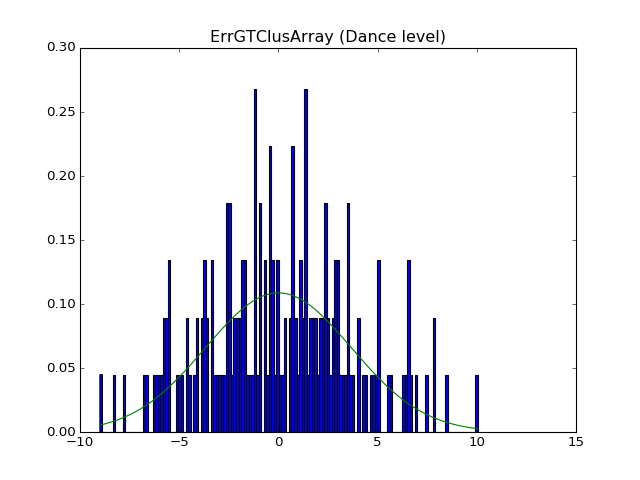

In [12]:
#Graphic ErrGTClusArray distribution (each GT file)
lim = 150
#An array containing all keys to WRuns with errors over the limit is generated
ErrGTKey = [key for key, value in ErrGTClusArray.items() if np.max(np.abs(value)) > lim]
#and the errors under that limit
list_values = [value for key, value in ErrGTClusArray.items() if np.max(np.abs(value)) < lim]

list_values = np.array(list_values)

list_values = list_values[np.logical_and(list_values>-lim,list_values<lim)]

print(len(list_values))

mean=np.mean(list_values)
sigma=np.std(list_values)

print('mean = ' + str(mean))
print('std = ' + str(sigma))

fig3 = plt.figure()
plt.hist(list_values, bins=150, normed=True)

x = np.linspace(np.amin(list_values), np.amax(list_values), 200)
plt.plot(x, mlab.normpdf(x, mean, sigma))

plt.annotate('mean = %5.6f' %mean, xy=(-28, .075))
plt.annotate('std = %5.6f' %sigma, xy=(-28, .07))

plt.title("ErrGTClusArray (Dance level)")
plt.show()

22
mean = -3.26892428404
std = 5.47650403319


<IPython.core.display.Javascript object>


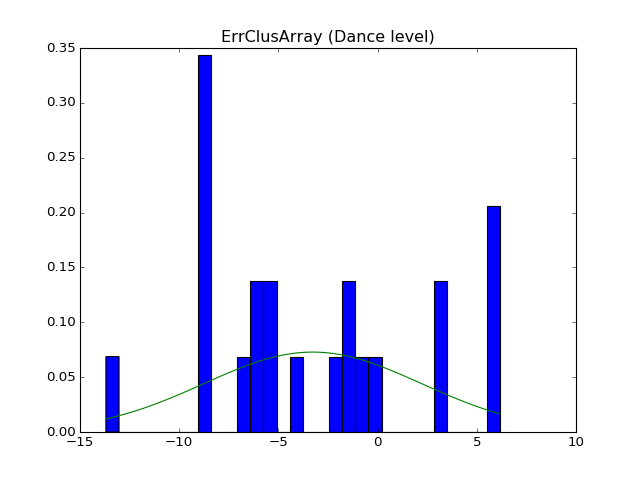

In [17]:
#For ErrClusKey
lim = 150
#An array containing all keys to WRuns with errors over the limit is generated
ErrClusKey = [key for key, value in ErrClusArray.items() if np.max(np.abs(value)) > lim]
#and the errors under that limit
list_values = [value for key, value in ErrClusArray.items() if np.max(np.abs(value)) < lim]

list_values = np.array(list_values)

print(len(list_values))

mean=np.mean(list_values)
sigma=np.std(list_values)

print('mean = ' + str(mean))
print('std = ' + str(sigma))

fig4 = plt.figure()
plt.hist(list_values, bins=30, normed=True)

x = np.linspace(min(list_values), max(list_values), 100)
plt.plot(x, mlab.normpdf(x, mean, sigma))

plt.annotate('mean = %5.6f' %mean, xy=(-28, .08))
plt.annotate('std = %5.6f' %sigma, xy=(-28, .075))

plt.title("ErrClusArray (Dance level)")
plt.show()

In [ ]:
#Notebook's sandbox

#########################################################################
#Load GTData from all users, calculate an average value for each WRun and store them in GTAverage.csv

#GROUND TRUTH DATA
#Path to the Ground Truth data
path = '../Data/GTData'
folders = os.listdir(path)

#Ground Truth data is loaded
GTArray = {}
#Average Ground Truth
AvgGTArray = {}

for i in folders:    
    #Path to next GT file
    inputFile = os.path.join(path,i)
    print('working on ' + inputFile)
    with open(inputFile, 'rt', encoding='utf-8-sig') as GTFile:
        for row in csv.reader(GTFile, delimiter = ','):
            key = row[0]
            #If it is the first time this WR is registered
            if (key not in GTArray):
                GTArray[key] = [float(row[-1])]
            #If not, it is add
            else:
                GTArray[key].append(float(row[-1]))
for v in GTArray:
    #Average Ground Truth is computed using circular statistics with appropriate range
    AvgGTArray[v] = stats.circmean(GTArray[v], high=180, low=-180)

#All GTRuns
if (os.path.exists('../Data/GTAverage.csv')):
    os.remove('../Data/GTAverage.csv')

with open('../Data/GTAverage.csv', 'at', newline='') as out_file:
    writer = csv.writer(out_file, delimiter=',', quotechar=' ', quoting=csv.QUOTE_MINIMAL)        
    writer.writerow(['key, AvgGTAngle'])   
    for key in sorted(AvgGTArray.keys()):
        # key, GT_angle
        writer.writerow([key, AvgGTArray[key]/radi])

with open('../Data/GTAverage.json', 'w') as out_file:
    for key in sorted(AvgGTArray.keys()):
        # key, GT_angle
        json.dump([key, AvgGTArray[key]/radi], out_file)

#########################################################################

#To display histogram o dances on polar coordinates
#Number of bins
N = 40
#Decoder data adjusted to camera rotation
inputfile = '../Data/Filtering/20160816_13_Adj.csv'
Data = open(inputfile, 'rt', encoding='utf-8-sig')

#Angles of the runs are loaded
theta = []
theta = [float(row[1]) for row in csv.reader(Data, delimiter = ',')]
#With modulo operator angles are adjusted to the range [0, 2*pi]
mod_theta = [s % (2*np.pi) for s in theta]

#height is calculated through histogram
[height, angle] = np.histogram(mod_theta, bins = N)

width = 2*np.pi/N
width = angle[1] - angle[0]

fig3 = plt.figure()
fig3.suptitle('Waggle runs distribution for: ' + inputfile)
ax = plt.subplot(111, polar=True)


bars = ax.bar(angle[:-1], height, width = width)
for r,bar in zip(height, bars):
    bar.set_facecolor( cm.jet(r/10.))
    bar.set_alpha(0.4)

plt.show()

#########################################################################

for clus in sorted(AvgGTCluster.keys()):
    print(clus)
    print('AvgGTCluster {0}'.format(AvgGTCluster[clus]))
    print('GTClusters {0}'.format(GTClusters[clus][0]))
    print('ErrClusArray {0}'.format(ErrClusArray[clus]))
    print('GTClusArray {0}'.format(GTClusArray[clus][0]))
    print('ErrGTClusArray {0}'.format(ErrGTClusArray[clus][0]))